# **Hybrid Signal Compression**

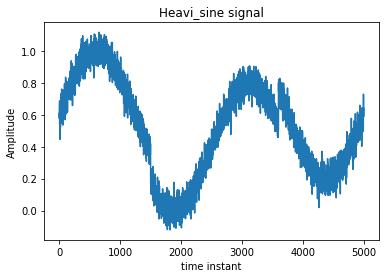

In [88]:
import numpy as np
import pywt
from pywt.data import demo_signal
import matplotlib.pyplot as plt
from scipy.fftpack import dct,idct
signal = demo_signal('HeaviSine',5000) 
signal = (signal - min(signal))/(max(signal)-min(signal))
demo = signal +  np.random.normal(0,0.05,5000)
plt.plot(demo)
plt.xlabel('time instant')
plt.ylabel('Amplitude')
plt.title('Heavi_sine signal')
plt.show()

In [124]:
################ Some useful fucntions is defined to be used later
def energy(x):
    return sum(x**2)/len(x)
def snr(s,orig):
  return 20*np.log10(abs(energy(orig)/(energy(s) - energy(orig))))
def rms(sgnl,orgnl):
  r  =sum( (sgnl[i]-orgnl[i]) **2 for i in range(len(orgnl)))/len(sgnl)
  return r

***STEP 1: DWT COMPRESSION AND NOISE REMOVAL***

In [126]:
###### DWT COMPRESSION FIRST DONE ON THE ORIGINAL SIGNAL ####

def dwt_compression(sgnl,th_p):
  coeff = pywt.wavedec(sgnl,'haar',level = 3,mode = 'constant' )     ###### cA3,cD3,cD2,cD1 are respectively the approximation and the detail coeffeints at the label(marked integer)
  cA3,cD3,cD2,cD1 = coeff
  cD3_new = pywt.threshold(cD3,th_p*(max(cD3)),mode='hard')         ###### These coeffs are hard thresholded such that all coeff less than the given thres is zeroed out
  c1 = list(cD3_new).count(0)
  cD2_new = pywt.threshold(cD2,th_p*(max(cD2)),mode='hard')         #### Done olny for the detail coeffs
  c2 = list(cD2_new).count(0)
  cD1_new = pywt.threshold(cD1,th_p*(max(cD1)),mode='hard')
  c3 = list(cD1_new).count(0)
  coeffs = cA3,cD3_new,cD2_new,cD1_new
  comp_ratio = 1-(c1+c2+c3)/len(demo)                               
  reconsoft = pywt.waverec(coeffs,'haar',mode = 'constant')        #### reconstruction of the signal based on the previous obtained coeffs
  snr4 = snr(reconsoft,signal)
  rmsd = rms(reconsoft,signal)
  plt.plot(reconsoft,c='g',label = 'compression ratio:[%1.2f]\nSNR : [%s]\nRMSD[%1.8f] : ' %(comp_ratio,snr4,rmsd))
 
  return reconsoft


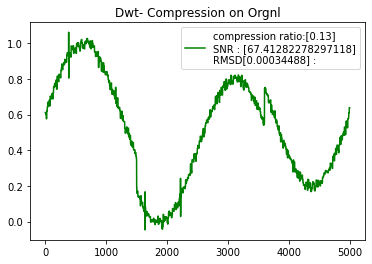

In [127]:
dwt_procsd = dwt_compression(demo,0.99)
plt.title('Dwt- Compression on Orgnl')
plt.legend()
plt.show()

***STEP 2: DCT COMPRESSION***

In [116]:
def dct_compress(sgnl,fraction,th):        #### fraction specifes the number of fractions I want to break my signal into
    N = len(sgnl)
    recon = np.array([])
    iter = int(1/fraction)
    c = 0
    for j in range(iter):
        clip_sgnl = sgnl[int(j*fraction*N):int((j+1)*fraction*N)]
        sgl_tr = dct(clip_sgnl)                                       ####### for each component dct is calculated,thresholded and inverted
        coeff = pywt.threshold(sgl_tr,th*max(sgl_tr))
        c = c+list(coeff).count(0)
        
       
        id_ct = idct(coeff)/2/len(clip_sgnl)
        recon = np.append(recon,id_ct)
        # print(len(recon))
    comp_ratio = 1-c/len(sgnl)
    return recon,comp_ratio


5000
4765


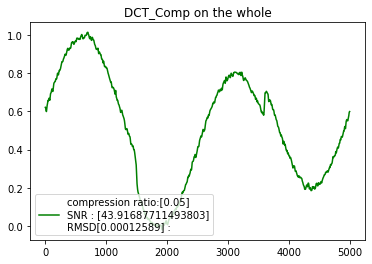

In [131]:
dr1,cf1 = dct_compress(dwt_procsd,1,0.001)
snrf1 = snr(dr1,signal)
rmsd1 = rms(dr1,signal)
plt.plot(dr1,c='g',label = 'compression ratio:[%1.2f]\nSNR : [%s]\nRMSD[%1.8f] : ' %(cf1,snrf1,rmsd1))
plt.legend(loc=3)
plt.title('DCT_Comp on the whole')
plt.show()

***Final compression ratio is the product of the two comp_ratios which is approximately 0.008 that is almost by a factor of 120 .***